## Clustering Notebook :

    This notebook is designed in an attempt to cluster the different earthquakes (mainshock and afterhsocks) since 1995 and of magnitude greater or equal to 3.5 (as defined in raw_data_exploration)

    The challenge is to process to unsupervised clustering, over a large amount of data. We can't use only a simple clustering algorithm but we need to process step by step in order to get relevant results.
    We will also process to outliers filtering as the data is hard to handle, because of the 3 dimensionality of our problem :
        - location (latitude,longitude)
        - time

    Finally, we will consider the results being sufficient if we can obtain convincing results for different known earthquakes:
        - the great tohoku earthquake (mag 9.1, Japan, 2011 : thousands aftershocks)
        -
        - 

In [1]:
import os
import warnings #for K-means memory leak on windows
import sys

import pandas as pd
import numpy as np

import geopandas as gpd

sys.path.append('../scripts')

from datetime import datetime
from datetime import date

#Personal functions

from data_download import download_data
from load_data import load_files, load_earthquakes_data

from preprocess_data import clean_db_data, filter_earthquake_database

from other_functions import valid_year, get_grid_cell, create_earth_grid
from clustering import create_cells_chain_clusters, cluster_shocks_by_temporal_feature

from plot_data import plot_DFS_Kmeans_grid,plot_cluster,custom_marker_size

    useful variables (path, filename, maps...), warning due to scikit K-Means clustering algorithm, which has memory leak issue on Windows OS

    useful variables (path, filename, maps...), warning due to scikit K-Means clustering algorithm, which has memory leak issue on Windows OS

In [2]:
warnings.filterwarnings('ignore')

usgs_folder_path="../ressources/usgs"
pop_folder_path ="../ressources/population"
current_year = datetime.now().year
current_directory = os.getcwd()
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
clusters_folder_path = os.path.join(current_directory,'../ressources/clusters')
clusters_filename = 'clusters_dataset.csv'
if not os.path.exists(clusters_folder_path):
    os.makedirs(clusters_folder_path)

cluster_file_path = os.path.join(clusters_folder_path,clusters_filename)


    Hypothesis :
    An earthquake can have faults of different lengths. There is no "common length" for an earthquake, but we know that
    one of the longest recorded earthquake faults was the San Andreas Fault in California, which is approximately 1,200 kilometers long.
    Also, the finit faults can have various shapes, close to a straight line, curved, or much more complex.

    According to this, we know that our clusters should be able to cover a length of at least 1200km if it's a straight line.
    As one cell is of size 39x39 km, with an hypotenus of 54.95 km, and an area of 1510 km²,
    we need clusters of at least 1200/39 = 31 cells to cover the San Andreas fault, if we imagine it as a straight line.
    On the other hand, we know that earthquakes aftershocks can occur hundreds of kilometers far from the fault.
    Extending our distance to 300km from each side of the fault, we arrive to 1200+2*300 = 1800 km.
    Now we arrive to 47 cells. To add a small margin error, we can go up to 50 cells per cluster of cells.

    With clusters of cells of size up to 50 cells, to give an idea about the different possible shapes we can cover:
        - if we have a straight line of 50 cells, we cover a length of 1943 km.
        - if we have a square of size 7x7 cells, we cover 272x272 km (75 000 km²)

In [4]:
# Useful variables
prev_years = 53 #number of years back in time to download data


mag_noise_threshold = 3.5   #after raw_data exploration
min_mag = 5.                #after raw_data exploration
threshold_year = 1995       #after raw_data exploration
date_threshold = date(threshold_year, 1, 1)

depth_drop_range = [120,450] #not used for the moment, could be to focus on specific depth

earth_area = 510.1e6 #square km
earth_circ = 40075 #km
min_latitude, max_latitude, min_longitude, max_longitude  = -90, 90,- 180 , 180

large_cell_cluster_size = 10*5 #needs to find optimal value here for cells clustering
cell_cluster_margin = large_cell_cluster_size//2


    Parameters :
        - large_cell_cluster_size = 10*5
        - cell_cluster_margin = large_cell_cluster_size//2

    (old) gived very good results with :
        - k_plus = 2
        - eps_value = 2.5e-4

---
#### step 1 : load data

In [5]:
download_data(prev_years, folder_path=usgs_folder_path)

Year 2023 -> file too large... splitting into 2
Year 2023, part 1 -> file downloaded


Year 2023, part 2 -> file downloaded


In [6]:
data_files = load_files("earthquake",folder_path=usgs_folder_path)
fyear = valid_year(data_files, fyear = threshold_year)

In [7]:
earthquake_db = load_earthquakes_data(start_year = fyear, end_year = current_year, files_list = data_files, folder_path= usgs_folder_path)
initial_size = earthquake_db.size

using 50 files over 29 years.



---
#### step 2 : dirty data filtering

    statement : the 'NaN' values in the 'mag_error', 'depth_error', 'latitude_error' columns are considered as if there is no error in the measurement ('NaN' = 0). The filtering is applied to non-nan values.

    The distribution of earthquakes incertitudes do not follow a known mathematical distribution such as Uniform or Gamma. However we have a very large number 'n' of data points which are not 'NaN' values. Then, we can apprehend the confidence in our incertitudes columns as if it follows a normal distribution with unknown variance. This allows us to consider a filtering based on the '2-sigma rule', but here using 3-sigma. It should filter outliers until 99% of confidence.

    The NaN values are replaced by 0 (could be the median if we consider it's just a lack of data, to fill with a typical value)

In [8]:
earthquake_db = clean_db_data(earthquake_db,date_threshold,mag_noise_threshold,min_mag)
f"shape of dataframe used for clustering : {earthquake_db.shape[0]} rows, {earthquake_db.shape[1]} columns"

filtering earthquake database for earthquakes after 1995-01-01 and ensure absence of mistakes in database by dropping earthquakes of mag < 3.5...

filtering 'X_Error' columns. If an 'X_Error' value is not a NaN and outside 3 sigma, we drop the row (inaccurate data). NaN values are replaced by median:

horizontalError old nan value : 284908
median error in horizontalError : 7.9
horizontalError new nan value : 0
-----------------------------------
depthError old nan value : 184622
median error in depthError : 5.912
depthError new nan value : 0
-----------------------------------
magError old nan value : 273096
median error in magError : 0.118
magError new nan value : 0
-----------------------------------


'shape of dataframe used for clustering : 432414 rows, 10 columns'

---

## Create Earth Grid

    A commonly used method to study the evolution of an ecosystem in the forest or in a field of large dimension is to subdivide the surface into smaller blocks, considered as samples. A similar approach can be used in our case : the earth is a very large surface that can't be apprehended as a whole in machine learning, if we want efficiency.

    In order to have a spatial representation of where we are located on earth, we often use (latitude,longitude) locations. Latitude and longitudes are expressed in degrees (°), and we can roughly approximate 1° to 111 km. The latitudes are going from -90° to +90°, while the longitude go from -180° to 180°.  The most famous latitude being the equator (lat 0°), while the most famous longitude is the Greenwich meridian (lon 0°). 
    This type of coordinates allows to divide the earth surface into smaller surfaces, like rectangles or squares.
    To facilitate the spatial representation, we will use samples of square size. The size of a cell (sample) has been designed to be of approximately 1500 square kilometers, which is bigger than the London area. 

    You can adjust these parameters to get different sample size, but we can't guaranty the results.


next formulas are slightly approximated:
to calculate the distance by one degree of latitude and longitude at a specific latitude $\theta$ with good accuracy, we can use:

1) Latitude:
length of one degree of latitude (north-south) in kilometers is:
- $1° Latitude (km) = 111.4 - 0.1 * cos(2\theta)$

2) Longitude:
- $1° Longitude (km) = 111.32 * cos(\theta)$

In [9]:
grid, step = create_earth_grid(power_scale = 4, step_num = 7)

In [10]:
earthquake_db['grid_cell'] = get_grid_cell(earthquake_db['latitude'], earthquake_db['longitude'], step) #we assign to each shock the cell number on the grid

num_latitude_cells, num_longitude_cells = grid.shape[0], grid.shape[1]
nb_cells = num_latitude_cells*num_longitude_cells

f"we obtain a grid of {num_latitude_cells} rows, {num_longitude_cells} columns, so {nb_cells} cells in total"

'we obtain a grid of 411 rows, 822 columns, so 337842 cells in total'

In [11]:
unit_area = round(earth_area/nb_cells,2)
long_lat_ratio = np.sqrt(unit_area)
hypothenus = np.sqrt(long_lat_ratio**2*2)

f"each square cell has side of approximately {round(long_lat_ratio,2)} km, with a diagonal of {round(hypothenus,2)} km. This represents a surface of {unit_area} km²"

'each square cell has side of approximately 38.86 km, with a diagonal of 54.95 km. This represents a surface of 1509.88 km²'

---

### Split Big and Small shocks

    earthquakes are mainly concentrated at the boundary between the different tectonic plates. in these areas, a lot of movement beneath the earth surfaces leads to subduction phenomenea, that can lead to earthquakes. When we reshaped the earth into a grid of cells, we did not consider the areas containing earthquakes and the ones without shocks. As we will have to look for cell adjency in the future, we need to keep only the cells containing data (faster to retrieve in a list of length 10 000 than of len 300 000 !)

    Also, we know that most of the time, only earthquakes of magnitude greater or equal to 5 produces aftershocks. In our study, as we want to study the shocks that can potentially lead to aftershocks, we need to separate what we will call 'big shocks' and the 'small shocks'. We note that some 'big shocks' can be aftershocks, and some 'small shocks' can be mainshocks. However, we will not work on cluster with a mainshock of mag < 5.

In [12]:
#reduced_db is not different from earthquake_db as long as we do not apply the depth filter
reduced_db, big_earthquake_db, small_earthquakes, min_mag, max_mag = filter_earthquake_database(earthquake_db, threshold_year = threshold_year, min_mag = min_mag, depth_drop_range = depth_drop_range)

In [13]:
big_shock_cells_list = big_earthquake_db['grid_cell'].tolist()
big_shock_unique_tuples = list(set(big_shock_cells_list)) #we do not need duplicates

f"only {len(big_shock_unique_tuples)} cells contain a shock at least of mag 5, over the {nb_cells} of the grid ({round(len(big_shock_unique_tuples)/nb_cells*100,2)}%)"

'only 11359 cells contain a shock at least of mag 5, over the 337842 of the grid (3.36%)'

    in the filtered database, we count the number of shocks per cell. if a cell has no shock at all inside, we can just drop the cell. 
    we also distinguish the cells containing big shocks and the one only containing small shocks. If a cell containing only small shocks has no adjency with a cell with big shocks (will be used in the cells clustering part!), we know that we don't have to keep the data related to this cell!

In [14]:
#first, we count the number of earthquake in each grid cell with data
total_earthquakes_per_cell = reduced_db['grid_cell'].value_counts().reset_index()
total_earthquakes_per_cell.columns = ['grid_cell', 'TotalEarthquakes']

#then, we count the number of big shoks in each cell with data
total_big_shocks_per_cell = big_earthquake_db.groupby('grid_cell')['BigShock'].agg(['sum'])
total_big_shocks_per_cell.rename(columns={'sum': 'BigShocks'}, inplace=True)

#then we merge the 2 data frames; the cells with no Bigshock are filled with 0 for "BigShocks"
result_df = total_earthquakes_per_cell.merge(total_big_shocks_per_cell, on='grid_cell', how='left').fillna({'BigShocks': 0})
result_df['MinorShocks'] = result_df['TotalEarthquakes'] - result_df['BigShocks']
result_df = result_df.sort_values("BigShocks", ascending=False).reset_index(drop=True)

#these are the cells that don't contain any big shock, among the cells with data
no_bigshock_cells = result_df[result_df['BigShocks'] == 0].grid_cell.tolist()

In [15]:
#these are the cells containing at least one earthquake of any magnitude
cells_with_data = result_df.grid_cell.tolist()

In [16]:
f"we will only work on {len(cells_with_data)/(nb_cells)*100}% of the cells (percentage of cells containing data!)" #we work only on x % of every cell

'we will only work on 8.743732277218344% of the cells (percentage of cells containing data!)'

In [17]:
cell_index_map = {cell: i for i, cell in enumerate(cells_with_data)}

---

## Spatial cells clustering

    With the hardware we have on our laptops, we clearly dont have the ability to apply a DB-SCAN clustering algorithm over all of our data points, on both spatial and temporal dimensions. We need to find a solution to split the cells into smaller groups. What would streamline the process is to subdivide our 'big' clustering process into smaller clustering processes (involving K-Means, DB-SCAN...).
    In this idea, we can use the geospatial property of earthquakes. We know that they mostly occur on tectonic plates boundaries. And still, they are not always linked. This suggests that we can intend to create groups of cells (clusters of cells), using a simple iterative method: The iterative depth first search (DFS, https://www.geeksforgeeks.org/iterative-depth-first-traversal/).

    The algo in short:

    For each cell, we look into the 8-adjacent cells if there is another cell containing data (we know these cells thanks to the cell_index_map). If yes, we group the 2 cells. And from the new cell, we apply the same strategy : if there is another cell in the 8-adjacency containg at least one shock, we add it in the cluster.
    This strategy allows to capture the different shapes of earthquakes clusters (only in the spatial dimension).

    However, due to our data specificity, in some areas of high seismicity (mostly near Asia), we create cells cluster of very large size (thousands of cells!). These megaclusters of cells needs to be subdivided into smaller cell subclusters thanks to a K-Mean algorithm. This is applied in order to prepare cluster of cells of reasonable size to apply a simple temporal DB-SCAN on them.

    Cells clustering: around 50 seconds with my config @Ben

In [18]:
megaclusters_labels, megaclusters_data, adjacent_shocks_cells, isolated_shocks_cells = create_cells_chain_clusters(big_earthquake_db, no_bigshock_cells, cells_with_data, cell_index_map, num_latitude_cells,num_longitude_cells,large_cell_cluster_size, k_plus = 1)

Megacluster (1) Silhouette Coefficient with Noise as one cluster: 0.347
Megacluster (2) Silhouette Coefficient with Noise as one cluster: 0.421
Megacluster (3) Silhouette Coefficient with Noise as one cluster: 0.369
Megacluster (4) Silhouette Coefficient with Noise as one cluster: 0.591
Megacluster (5) Silhouette Coefficient with Noise as one cluster: 0.468
Megacluster (6) Silhouette Coefficient with Noise as one cluster: 0.522
Megacluster (7) Silhouette Coefficient with Noise as one cluster: 0.596
Megacluster (8) Silhouette Coefficient with Noise as one cluster: 0.525
Megacluster (9) Silhouette Coefficient with Noise as one cluster: 0.505
Megacluster (10) Silhouette Coefficient with Noise as one cluster: 0.475
Megacluster (11) Silhouette Coefficient with Noise as one cluster: 0.362
Megacluster (12) Silhouette Coefficient with Noise as one cluster: 0.402
Megacluster (13) Silhouette Coefficient with Noise as one cluster: 0.551
Megacluster (14) Silhouette Coefficient with Noise as one cl

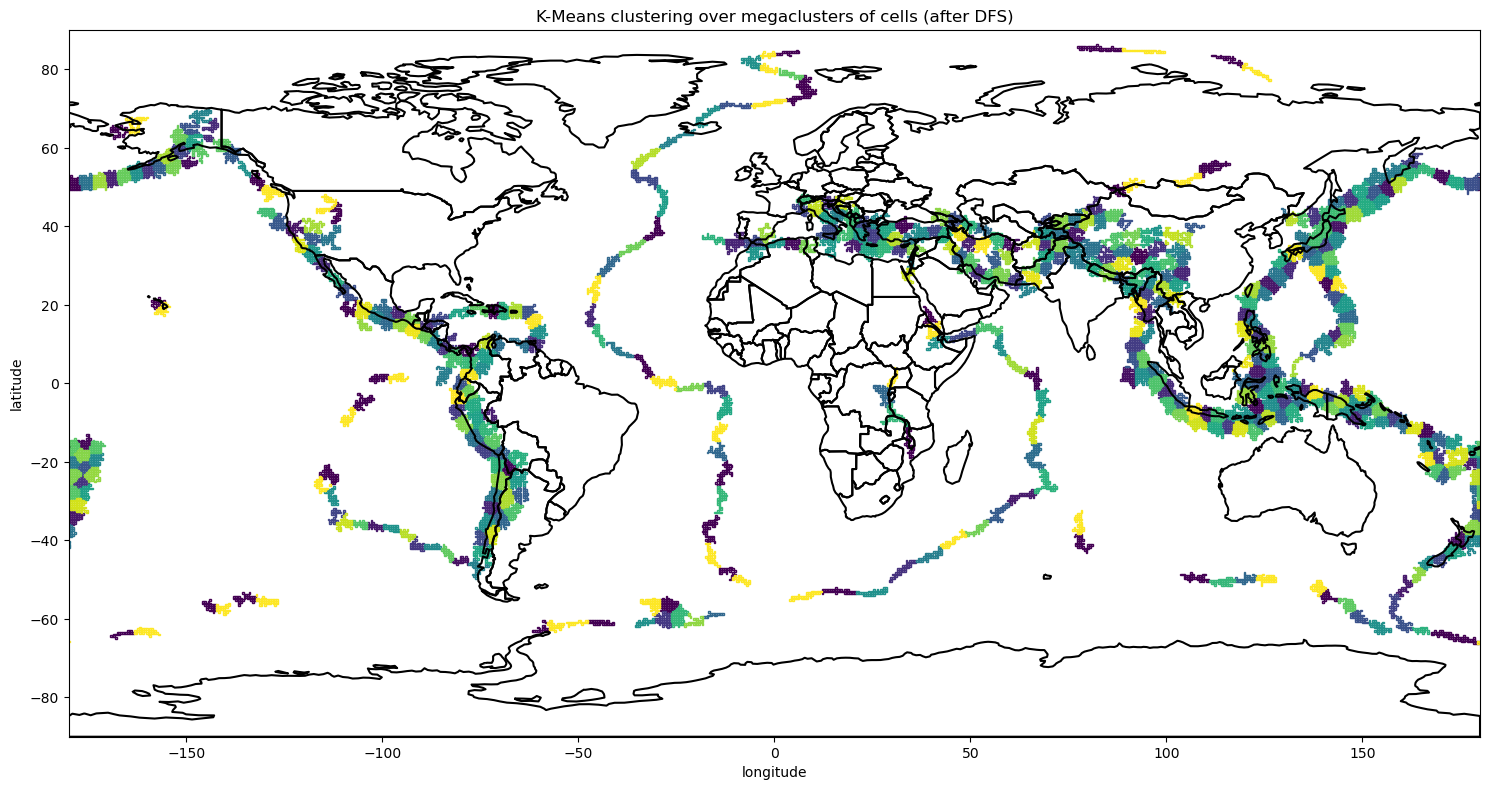

In [19]:
plot_DFS_Kmeans_grid(megaclusters_data,grid,world) #15 seconds approx

In [20]:
len(adjacent_shocks_cells), len(isolated_shocks_cells)

(339, 220)

In [21]:
mask = (result_df['grid_cell'].isin(isolated_shocks_cells)) & (result_df['BigShocks'] == 1) & (result_df['MinorShocks'] == 0)

one_shock_isolated_cluster = result_df.loc[mask, 'grid_cell'].tolist()
isolated_shocks_cells = [[cell] for cell in isolated_shocks_cells if cell not in one_shock_isolated_cluster]
one_shock_isolated_cluster = [[cell] for cell in one_shock_isolated_cluster]

print("one_shock_isolated_cluster:", one_shock_isolated_cluster)
print("updated isolated_shocks_cells:", isolated_shocks_cells)

one_shock_isolated_cluster: [[(138, 588)], [(158, 558)], [(313, 571)], [(214, 568)], [(172, 636)], [(236, 808)], [(172, 161)], [(121, 365)], [(134, 589)], [(307, 675)], [(167, 357)], [(247, 277)], [(224, 159)], [(301, 627)], [(168, 610)], [(389, 165)], [(267, 573)], [(114, 55)], [(83, 236)], [(157, 445)], [(116, 598)], [(200, 518)], [(94, 152)], [(132, 613)], [(239, 760)], [(168, 147)], [(47, 159)], [(198, 605)], [(237, 296)], [(231, 119)], [(76, 817)], [(195, 624)], [(159, 518)], [(167, 25)], [(76, 307)], [(97, 777)], [(79, 72)], [(84, 300)], [(191, 243)], [(192, 130)], [(81, 270)], [(205, 614)], [(46, 789)], [(221, 749)], [(308, 628)], [(56, 247)], [(379, 697)], [(81, 318)], [(282, 454)], [(219, 181)], [(185, 612)], [(139, 632)], [(342, 742)], [(80, 453)], [(217, 35)], [(163, 107)], [(239, 676)], [(195, 242)], [(219, 748)], [(93, 750)], [(188, 630)], [(383, 458)], [(105, 180)], [(204, 384)], [(168, 683)], [(358, 820)], [(319, 743)], [(31, 786)], [(41, 122)], [(155, 616)], [(139, 402)

In [22]:
print(f"We can already form {len(one_shock_isolated_cluster)} clusters of one unique big shock and no aftershock.")
print(f"We reduced the number of isolated cells with multiple shocks to only {len(isolated_shocks_cells)} cells.")

We can already form 168 clusters of one unique big shock and no aftershock.
We reduced the number of isolated cells with multiple shocks to only 52 cells.


In [23]:
## NOW WE TRANSFORM OUR LISTS OF LISTS SO EVERYTHING HAS THE SAME FORMAT (dict of dict, with appropriate labels)
adjacent_shocks_dict = {}
isolated_shocks_dict = {}

start_key= len(megaclusters_labels)

for i, cell_list in enumerate(adjacent_shocks_cells):
    adjacent_shocks_dict[start_key + i] = {0:cell_list}

start_key= len(megaclusters_labels)+len(adjacent_shocks_dict)
for i, cell_list in enumerate(isolated_shocks_cells):
    isolated_shocks_dict[start_key + i] = {0:cell_list}

    Let's try to use so mathematics to understand the behavior of our model when we tend to infinite time:
        - let's 'Nu' be the number of cells with only one unique big shock and no aftershock
        - let's 'Ni' be the number of isolated cells with multiple shocks

        our data was gathered only on the last 30 years. however, over this huge period of time, we only have
        163 with only one shock and only 47 isolated cells. AS they are new earthquakes everyday, we can think
        that for a long period of time, the number of cells with only one unique shock will decrease over time.
        Same, the number of isolated cells will reduce as the plate tectonic will make the plates slide 
        progressively over the earth surface.
        so for time 't' -> inf : Nu -> 0, Ni -> 0

        in the same way, the size of the clusters created with the iterative DFS will tend to the number of cells on our earth grid.
        


In [24]:
all_clusters_dict = { **megaclusters_data, **adjacent_shocks_dict, **isolated_shocks_dict}

In [25]:
subclusters_total = 0
for megacluster_label, megacluster_data in all_clusters_dict.items():
    subclusters_total += len(megacluster_data)
    
subclusters_total

877

----


## Temporal DBSCAN on spatial cells clusters

    Because of the K-means algorithm applied on large megaclusters of cells, some earthquakes clusters can be split spatially.
    
    Then, a spatio temporal (ST) cluster of earthquakes can have an epicenter in one subcluster and aftershocks in adjacent subclusters. To avoid losing the data in the adjacent subclusters, we need to proceed to a spatio temporal clustering over the subcluster itself AND its adjacent subclusters. We can call this structure 'intermediate cluster'. In short, it's a cluster of cells created from the subcluster (of cells) and its adjacent clusters (of cells).

    Let's find all ST-clusters of earthquakes inside a subcluster of cells named 'S' which have an epicenter in S:
    
    We process to the ST DBSCAN over the structure linked to S. This creates a certain number of ST (spatio temporal) clusters (of earthquakes) in the intermediate cluster. However, some earthquake clusters have for epicenter an adjacent subcluster (of cells), which is not S. But maybe this ST cluster of earthquakes has other aftershocks in its own adjacents subclusters (of cells) that are not the same as S. So we can't keep it,  because maybe some of its aftershocks are not considered. However, we are (-quite very-) sure that the ST cluster which have for origin the S subcluster are all complete, because we also looked for the data in its adjacent subclusters.
    This is why we only keep the ST clusters that have for origin the subcluster S.

    Then the operation is applied over all the other subclusters.

        nb : using bigger cell sizes would only shift the issue : what if a cluster is located at the border of two cells ?...

In [26]:
cluster_dict = cluster_shocks_by_temporal_feature(all_clusters_dict,megaclusters_data,megaclusters_labels,big_earthquake_db,small_earthquakes,num_latitude_cells,num_longitude_cells,subclusters_total, high_quality = True)

area 0/877 : 0.11% completed
area 25/877 : 2.96% completed
area 50/877 : 5.82% completed


Computing time for temporal clustering of the shocks on my laptop (16 GO RAM, 2.30 GHz):
around 5 min according to epsilon, if plugged into the mains, and only program running.
@Ben config

        'st' stands for 'spatio temporal'

In [ ]:
spatio_temporal_clusters = 0
max_mag_list = []

for spatial_megacluster_label, spatial_megacluster_data in cluster_dict.items():
    for spatial_subcluster_label, spatial_subcluster_data in spatial_megacluster_data.items():
        spatio_temporal_clusters += len(spatial_subcluster_data)
        for ST_cluster_label, ST_cluster_data in spatial_subcluster_data.items():
            max_mag_list.append(ST_cluster_data.mag.max())
        
spatio_temporal_clusters

In [ ]:
dfs = []
st_cols = ['grid_cell','id','time','latitude','longitude','depth','mag','nearest_area','delta_days','delta_dist','delta_depth','delta_mag']
for spatial_megacluster_label, spatial_megacluster_data in cluster_dict.items():
    for spatial_subcluster_label, spatial_subcluster_data in spatial_megacluster_data.items():
        for ST_cluster_label, ST_cluster_data in spatial_subcluster_data.items():
            max_mag_list.append(ST_cluster_data.mag.max())
            df = ST_cluster_data[st_cols].copy()
            df['MC_lab'] = spatial_megacluster_label
            df['SC_lab'] = spatial_subcluster_label
            df['ST_lab'] = ST_cluster_label
            dfs.append(df)
            
clusters_df = pd.concat(dfs, ignore_index=True)
column_order = ['MC_lab', 'SC_lab', 'ST_lab'] + st_cols
clusters_df = clusters_df[column_order]

In [ ]:
clusters_df.to_csv(cluster_file_path, index = False)

In [ ]:
clusters_df.info()

In [ ]:
clusters_df.head(10)

In [ ]:
clusters_df.describe()

In [ ]:
np.quantile(max_mag_list,[0.05,0.25,0.5,0.75,0.95])

---

## Plot Example

In [ ]:
area_of_interest = 'Japan'  #
min_mag_of_interest = 8.6  # 5 if no specific condition
max_mag_of_interest = 10   #10 if no specific condition

In [ ]:
days_threshold = True
x_days_threshold = 32
aftershocks_only = True

In [ ]:
for spatial_megacluster_label, spatial_megacluster_data in cluster_dict.items():
    
    for spatial_subcluster_label, spatial_subcluster_data in spatial_megacluster_data.items():
        
        for spatio_temporal_cluster_label, cluster_data in spatial_subcluster_data.items():
            if len(cluster_data)>=200:
                cluster_data = cluster_data[cluster_data['mag']>=4.5].reset_index(drop=True)
            if days_threshold:
                cluster_data = cluster_data[cluster_data['delta_days']<=x_days_threshold].reset_index(drop=True)
            if aftershocks_only:
                cluster_data = cluster_data[0<=cluster_data['delta_days']].reset_index(drop=True)
            
            if len(cluster_data)==0:
                continue
            mag_max_idx = cluster_data.mag.idxmax()
            mag_max = cluster_data.mag.max()
            mag_min = cluster_data.mag.min()
            
            if (min_mag_of_interest <= mag_max <= max_mag_of_interest) and len(cluster_data)>=100:
                        
                    near_areas = set(cluster_data.nearest_area.tolist())
                    if area_of_interest in near_areas:

                        cluster_data['normalized_mag'] = (cluster_data['mag'] - mag_min) / (mag_max - mag_min)
                        cluster_data['marker_size'] = cluster_data['normalized_mag'].apply(custom_marker_size, args=(max_mag,))*1.2

                        max_magnitude_index = cluster_data['mag'].idxmax()
                        main_earthquake = cluster_data.loc[max_magnitude_index]
                        
                        if max_magnitude_index > 0:
                            foreshocks = cluster_data.loc[:max_magnitude_index - 1]
                        
                        aftershocks = cluster_data.loc[max_magnitude_index + 1:]
                        aftershocks_std = np.mean(aftershocks["delta_dist"])
                        aftershocks_mean = np.std(aftershocks["delta_dist"])
                        aftershocks = aftershocks[aftershocks['delta_dist']<= aftershocks_mean+2.5*aftershocks_std]
                        
                        degree = 6 if len(aftershocks)>=50 else 3
                        
                        near_area = main_earthquake.nearest_area
                        
                        dist_med= round(np.median(aftershocks['delta_dist']),2)
                        mag_med = round(np.median(aftershocks['mag']),2)
                        
                        mag_std = round(np.std(aftershocks['mag']),2)
                        dist_std= round(np.std(aftershocks['delta_dist']),2)
                        
                        mag_mean = round(np.mean(aftershocks['mag']),2)
                        dist_mean = round(np.mean(aftershocks['delta_dist']),2)
                
                        try:
                            max_dist_index = aftershocks['delta_dist'].idxmax()
                            max_dist_delta_dist = aftershocks.loc[max_dist_index]['delta_dist']
                            max_dist_delta_time = aftershocks.loc[max_dist_index]['delta_days']
                            max_dist_mag = aftershocks.loc[max_dist_index]['mag']

                            print(spatial_megacluster_label,spatial_subcluster_label,spatio_temporal_cluster_label,len(cluster_data))
                            
                            print(main_earthquake.grid_cell)
                            print(main_earthquake.mag, len(aftershocks))
                            
                            print(f"Aftershock magn mean: {mag_mean}")
                            print(f"Aftershock dist mean: {dist_mean}")
                            print()
                            print(f"Aftershock magn std: {mag_std}")
                            print(f"Aftershock dist std: {dist_std}")
                            print()
                            print(f"Aftershock biggest dist: {round(max_dist_delta_dist,2)} (delta days : {round(max_dist_delta_time,2)}, mag : {max_dist_mag})")
                            print()
                            
                            
                            plot_cluster(world,grid,cluster_data, main_earthquake, aftershocks, max_magnitude_index,mag_med, near_area, degree = degree,mag_power = 4)

                        except:pass
            